### Take a look at the Google Drive where the dataset is stored, along with previous versions of the notebook, to get a better understanding of the thought process I’ve followed:
https://drive.google.com/drive/folders/1jBOFqkPyN-_daZR1IP7_eBGHi-bKBHns?usp=sharing

In [1]:
from IPython import get_ipython

# method to check if the dependencies needs to be installed
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install tensorflow opencv-python matplotlib mediapipe
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not running in Google Collab")

Not running in Google Collab


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import random
import concurrent.futures

In [3]:
#! Quentin

GOOGLE_PATH = "./drive/MyDrive/moonshot/squat/"

In [4]:
# Constants

#! Made constants for WIDTH and HEIGHT

# Define the dimensions of the frames
WIDTH = 240
HEIGHT = 320
NUM_CLASSES = 4

# Define paths and sequences length
DATA_PATH = GOOGLE_PATH + '/dataset/quentin/3/frames'
actions = ['correct', 'depth', 'heels lifting', 'knee cave']
SEQUENCE_LENGTH = 150  # Number of frames to consider in each sequence

# Load the mediapipe model
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [5]:
import cv2

def resize_image(image, target_width=WIDTH, target_height=HEIGHT):
    """
    Resize an image to a target width and height while keeping the original aspect ratio.
    If the original aspect ratio is different from the target aspect ratio, the resized image is padded with zeros.
    @param image: The image to resize
    @param target_width: The target width set to 240 by default
    @param target_height: The target height set to 320 by default
    @return: The resized image
    """
    original_height, original_width = image.shape[:2]
    original_aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height

    if original_aspect_ratio == target_aspect_ratio:
        resized_image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_AREA)
    elif original_aspect_ratio < target_aspect_ratio:
        scale_factor = target_height / original_height
        new_width = int(original_width * scale_factor)
        resized_image = cv2.resize(image, (new_width, target_height), interpolation=cv2.INTER_AREA)
        pad_width = (target_width - new_width) // 2
        resized_image = cv2.copyMakeBorder(resized_image, 0, 0, pad_width, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        scale_factor = target_width / original_width
        new_height = int(original_height * scale_factor)
        resized_image = cv2.resize(image, (target_width, new_height), interpolation=cv2.INTER_AREA)
        crop_height = (new_height - target_height) // 2
        resized_image = resized_image[crop_height:crop_height + target_height, :]

    return resized_image

In [6]:
def extract_pose_keypoints(results):
    """
    Extract pose keypoints from MediaPipe results.
    @param results: MediaPipe results
    @return: Flattened array of pose keypoints
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

In [20]:
# Function to process the frames using MediaPipe
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True                    # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR COVERSION RGB to BGR
    return image, results

In [21]:
# Function to check if the squat depth is sufficient
def is_depth_sufficient(results):
    """
    Check if the depth of the squat is sufficient.
    @param results: MediaPipe results
    @return: True if the depth is sufficient, False otherwise
    """
    if results.pose_landmarks:
        left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
        right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
        left_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE]
        right_knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE]
        hips_height = (left_hip.y + right_hip.y) / 2
        knees_height = (left_knee.y + right_knee.y) / 2

        # Check if hips are lower than knees and print the result
        if hips_height > knees_height:
            return True
    return False

In [22]:
# Initialize global variables
result_history = []

def mediapipe_debounce(DEBOUNCE_LIMIT, result):
    global result_history
    
    # Keep track of the last `DEBOUNCE_LIMIT` frames
    if len(result_history) >= DEBOUNCE_LIMIT:
        result_history.pop(0)  # Remove the oldest entry if limit is reached
    
    result_history.append(result)  # Add the current result to the history
    
    # Check if the number of True values in the history is at least 60% of the DEBOUNCE_LIMIT
    if result_history.count(True) >= 0.6 * DEBOUNCE_LIMIT:
        print("Sufficient Depth")

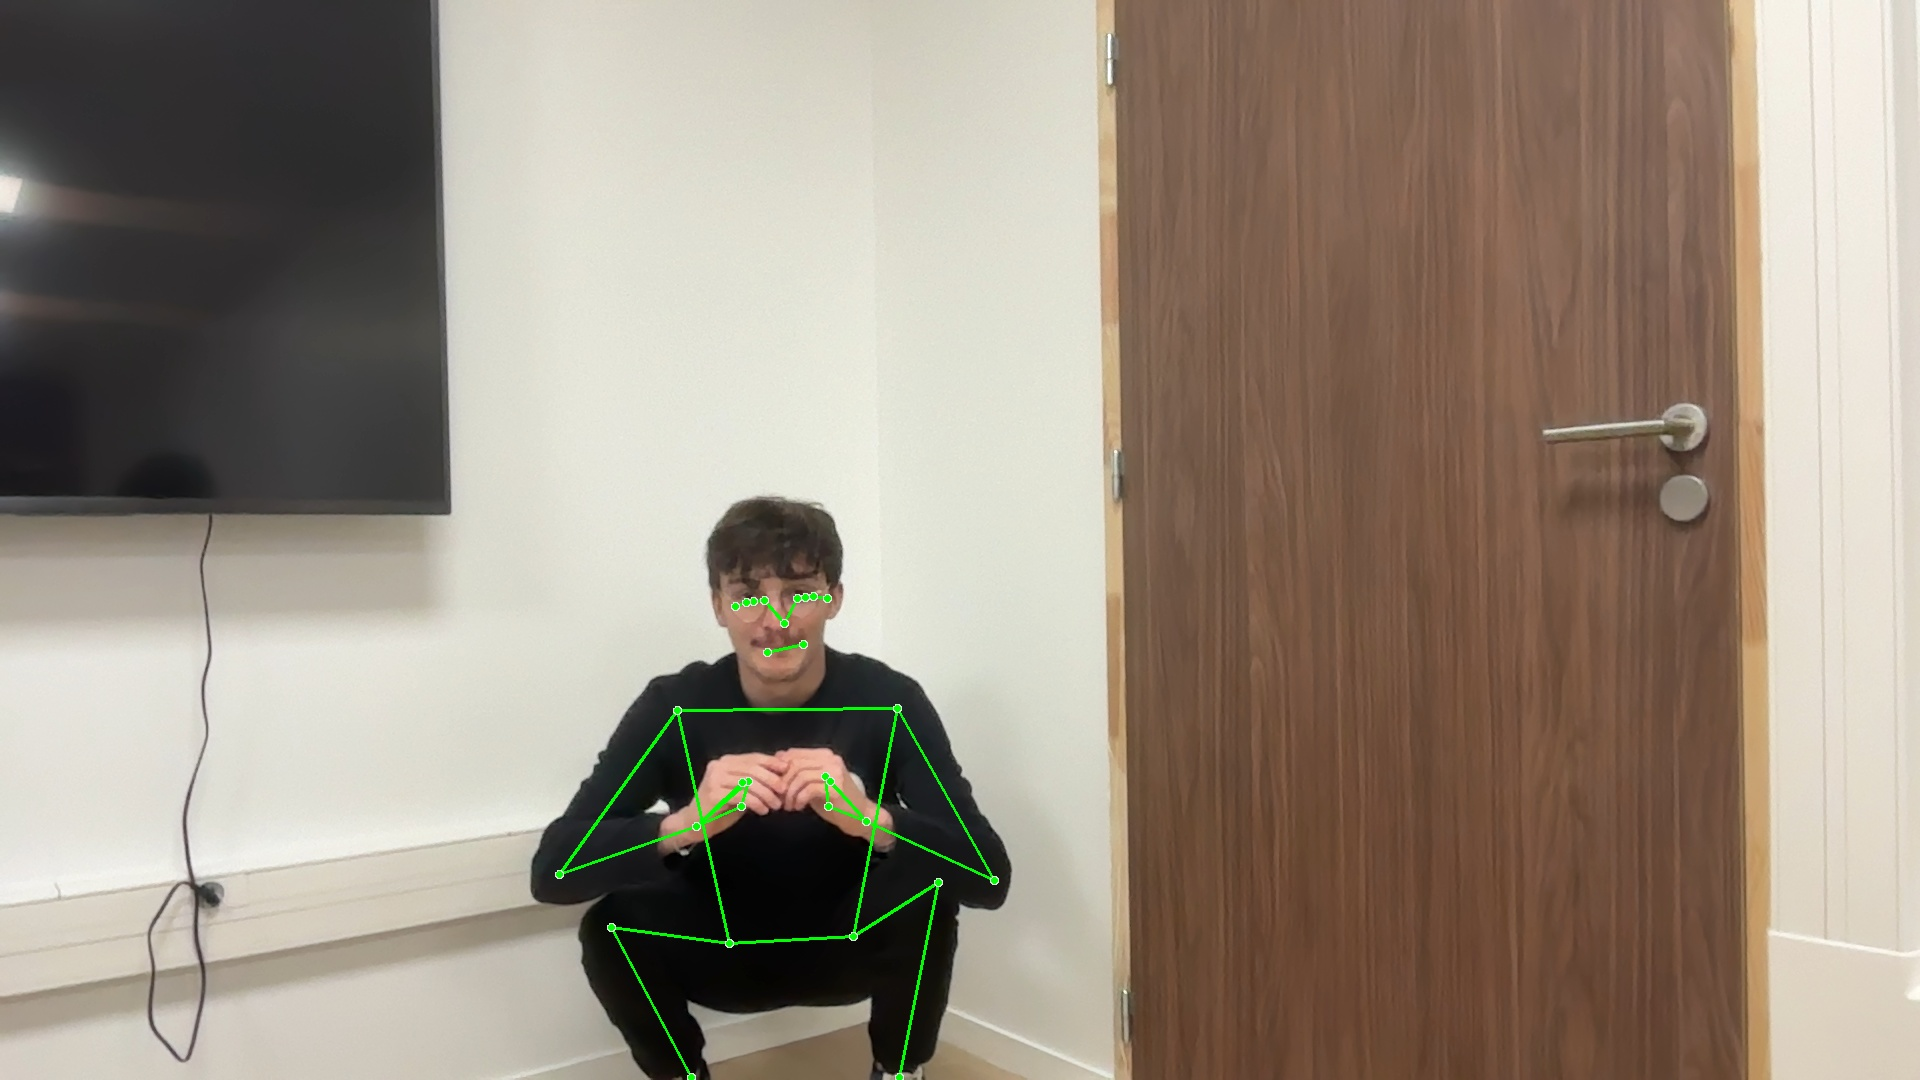

Sufficient depth detected! Exiting the loop.
Depth is sufficient
Deleted temporary file: ./temp_frame.jpg


In [28]:

from IPython.display import display, Image, clear_output

# Initialize the webcam feed
cap = cv2.VideoCapture(0)  # Use `0` for the default camera, or change to `1` for an external camera

# Boolean variable to track if sufficient depth was achieved
sufficient_depth_detected = False

# Counter for consecutive sufficient depth frames
consecutive_sufficient_depth_count = 0
CONSECUTIVE_THRESHOLD = 4  # Number of consecutive frames needed to set the boolean to True

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Apply MediaPipe detection
        image, results = mediapipe_detection(frame, pose)
        
        # Check if the squat depth is sufficient in this frame
        if is_depth_sufficient(results):
            consecutive_sufficient_depth_count += 1
        else:
            consecutive_sufficient_depth_count = 0

        # If sufficient depth is detected for 4 consecutive frames, set the boolean to True
        if consecutive_sufficient_depth_count >= CONSECUTIVE_THRESHOLD:
            sufficient_depth_detected = True
            print("Sufficient depth detected! Exiting the loop.")
            break  # Exit the loop as soon as sufficient depth is detected

        # Draw the keypoints and connections if detected
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=pose_drawing_spec,
                connection_drawing_spec=pose_drawing_spec
            )

        # Display the frame in Jupyter Notebook with keypoints
        clear_output(wait=True)  # Clear previous output
        temp_filename = "./temp_frame.jpg"  # Save frame temporarily
        cv2.imwrite(temp_filename, image)   # Save the frame as an image file
        display(Image(filename=temp_filename))  # Display the frame in Jupyter Notebook

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

# Check the final result
if sufficient_depth_detected:
    print("Depth is sufficient")
else:
    print("Depth isn't sufficient")

# Delete the temporary image file if it exists
if os.path.exists(temp_filename):
    os.remove(temp_filename)
    print(f"Deleted temporary file: {temp_filename}")

In [18]:
def extract_and_save_keypoints_as_numpy(video_path, output_dir, target_fps=30, max_frames=150):
    """
    Extract pose keypoints from a video file and save them as numpy arrays in the specified output directory.
    @param video_path: The path to the video file
    @param output_dir: The directory where the extracted keypoints will be saved
    @param target_fps: The frame rate at which to extract the frames
    @param max_frames: The maximum number of frames to extract
    """
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / target_fps)
    frame_count = 0
    saved_frame_count = 0
    last_keypoints = None

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % frame_interval == 0:
                # Convert the BGR image to RGB
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                # Process the image and extract the pose landmarks
                results = pose.process(image)

                # Extract keypoints
                keypoints = extract_pose_keypoints(results)
                frame_filename = os.path.join(output_dir, f'frame_{saved_frame_count:04d}.npy')
                np.save(frame_filename, keypoints)
                saved_frame_count += 1
                last_keypoints = keypoints

                if saved_frame_count >= max_frames:
                    break

            frame_count += 1

    # Duplicate the last frame if there are less than 150 frames originally
    while saved_frame_count < max_frames and last_keypoints is not None:
        frame_filename = os.path.join(output_dir, f'frame_{saved_frame_count:04d}.npy')
        np.save(frame_filename, last_keypoints)
        saved_frame_count += 1

    cap.release()
    print(f"Extracted and saved {saved_frame_count} frames for {video_path} as numpy arrays.")

In [ ]:
# Define the main paths
main_path = '/content/drive/My Drive/moonshot/squat/dataset/quentin/3'
frame_path = os.path.join(main_path, 'frames')
categories = ['correct', 'depth', 'heels lifting', 'knee cave']

# Create the frames directory if it doesn't exist
os.makedirs(frame_path, exist_ok=True)

In [ ]:
# Verify if the main path exists and list its contents
if os.path.exists(main_path):
    print(f"The main path exists: {main_path}")
    print("Listing contents of the main path:")
    print(os.listdir(main_path))
else:
    print(f"The main path does not exist: {main_path}")

# Loop through each category and process the videos
for category in categories:
    category_path = os.path.join(main_path, category)
    if os.path.exists(category_path):
        print(f"Processing category: {category}")
        videos = sorted(os.listdir(category_path))

        for video in videos:
            video_name = os.path.splitext(video)[0]
            video_path = os.path.join(category_path, video)
            output_dir = os.path.join(frame_path, category, video_name)
            extract_and_save_keypoints_as_numpy(video_path, output_dir)
    else:
        print(f"Category path does not exist: {category_path}")

print("Frame extraction and resizing complete.")

In [ ]:
def print_numpy_shapes(main_path, categories):
    """
    Print the shape of each numpy array saved in the specified directory and its subdirectories.
    @param base_path: The base directory containing category directories
    @param categories: List of categories to process
    """
    for category in categories:
        category_path = os.path.join(main_path, 'frames', category)
        for video_folder in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder)
            if os.path.isdir(video_folder_path):  # Ensure it's a directory
                for frame_file in os.listdir(video_folder_path):
                    frame_path = os.path.join(video_folder_path, frame_file)
                    if frame_path.endswith('.npy'):
                        frame = np.load(frame_path)
                        print(f"Shape of {frame_path}: {frame.ndim}")

# Print the shape of each numpy array
print_numpy_shapes(main_path, categories)

In [24]:
# Function to load a single frame from a numpy file
def load_frame(frame_path):
  """
  Load a single frame from a numpy file.
  @param frame_path: The path to the numpy file containing the frame
  @return: The loaded frame
  """
  if os.path.exists(frame_path):
    return np.load(frame_path)
  else:
      print(f"Frame {frame_path} does not exist, padding with zeros")
      return np.zeros((WIDTH, HEIGHT, 3))

In [25]:
# Function to load frames for a single sequence
def load_sequence(sequence_path, sequence_length):
    """
    Load frames for a single sequence.
    @param sequence_path: The path to the directory containing the frames for the sequence
    @param sequence_length: The number of frames in the sequence
    @return: The loaded frames
    """
    frame_paths = [os.path.join(sequence_path, f"frame_{i:04d}.npy") for i in range(sequence_length)]
    with concurrent.futures.ThreadPoolExecutor() as executor:
        frames = list(executor.map(load_frame, frame_paths))
    return frames

In [ ]:
# Create a label map
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

# Initialize sequences and labels as empty lists
sequences, labels = [], []

In [ ]:
# Loop through each action
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    if os.path.exists(action_path):
        for sequence in sorted(os.listdir(action_path)):
            sequence_path = os.path.join(action_path, sequence)
            window = load_sequence(sequence_path, SEQUENCE_LENGTH)
            sequences.append(window)
            labels.append(label_map[action])
    else:
        print(f"Action path {action_path} does not exist")

# Convert sequences and labels to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

print(sequences.shape)
print(labels.shape)

In [ ]:
# Prepare the data for training
X = sequences
y = to_categorical(labels).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(X_train.shape)
print(y_train.shape)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(SEQUENCE_LENGTH, 132)))
model.add(Dropout(0.5))

# Additional Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu')))
model.add(Dropout(0.5))

# Another LSTM Layer
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.5))

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(LayerNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(LayerNormalization())

# Output Layer
model.add(Dense(len(actions), activation='softmax'))

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=0.0005, clipvalue=1.0)  # Reduced learning rate and gradient clipping
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary
model.summary()

# Setup TensorBoard and EarlyStopping
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

X_train_processed = X_train.reshape(X_train.shape[0], SEQUENCE_LENGTH, 132)
X_test_processed = X_test.reshape(X_test.shape[0], SEQUENCE_LENGTH, 132)

# Train the model
history = model.fit(X_train_processed, y_train, epochs=100, validation_data=(X_test_processed, y_test), callbacks=[tensorboard, early_stopping])

In [ ]:
# Predictions
res = model.predict(X_test)

for i in range(len(y_test)):
    pred = actions[np.argmax(res[i])]
    truth = actions[np.argmax(y_test[i])]
    print(pred, truth)
